## Transformações dos dados (colocar dentro da pipeline)

In [29]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp,chi2_contingency
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
sys.path.append(r"C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super")
from utils.classes import FeatureBuilder
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc, precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance


In [3]:
dados = pd.read_csv(r'C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super\data\gold\dados_finais_gold.csv')

### Etapas:

- Separação treino e teste
    - Validação da separação dos dados

- Pipeline de transformação e criação de variaveis

- Modelos 
    - Random Forest
    - Regressão Logistica
    - Light GBM

- Avaliação dos modelos
    - Curva ROC AUC

- Estudos de threshold 

- Feature importance, outras análises

#### Transformações necessárias

In [4]:
dados = dados[dados['age']<=100]
dados['became_member_on'] = pd.to_datetime(dados['became_member_on'],errors='coerce')
dados['month'] = dados['became_member_on'].dt.month
dados = dados.drop(columns={'valor_total','valor_total_log'})

#### Treino e Teste

In [5]:
x = dados.drop(columns=['responded'])
y = dados['responded']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
num_cols = x_train.select_dtypes(include=[np.number]).columns

resultados_num = []
for col in num_cols:
    stat, p = ks_2samp(x_train[col], x_test[col])
    resultados_num.append({"variavel": col,"media_train": x_train[col].mean(),"media_test": x_test[col].mean(),"p_ks": p})
    
resultados_num = pd.DataFrame(resultados_num).sort_values("p_ks")

resultados_num

,variavel,media_train,media_test,p_ks
0,age,54.388968,54.117924,0.116141
9,time_total,399.756946,401.467983,0.462115
1,income,65392.908090,65365.546599,0.585306
10,month,6.677853,6.706548,0.758253
3,difficulty,7.737156,7.645231,0.839510
6,mobile,0.897720,0.903179,0.953651
4,duration,6.512805,6.489539,0.973721
8,web,0.798383,0.803007,0.991194
2,reward_offer,4.203813,4.211937,1.000000
5,email,1.000000,1.000000,1.000000


<Figure size 600x400 with 0 Axes>

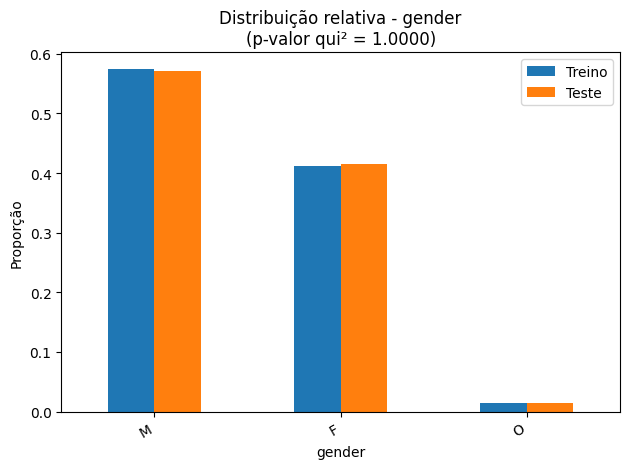

<Figure size 600x400 with 0 Axes>

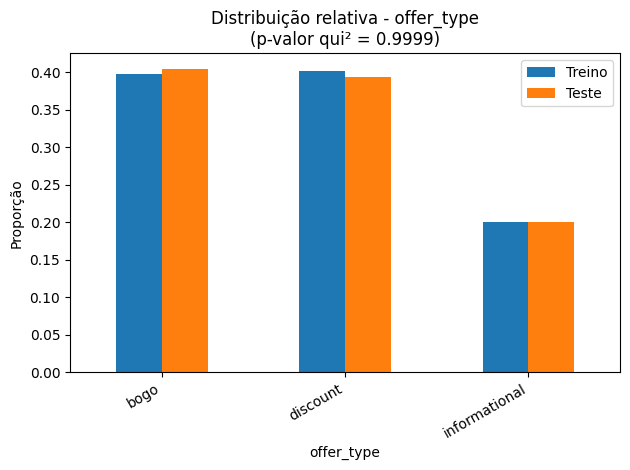

,variavel,p_chi2
1,offer_type,0.999930
0,gender,0.999968


In [7]:
cat_cols = x_train.select_dtypes(exclude=[np.number]).columns
cat_cols = cat_cols.drop(['offer_id','person','became_member_on'], errors='ignore') 
resultados_cat = []
for col in cat_cols:
    tabela = pd.crosstab(x_train[col], x_test[col])
    dist_train = x_train[col].value_counts(normalize=True)
    dist_test = x_test[col].value_counts(normalize=True)
    all_idx = dist_train.index.union(dist_test.index)
    dist_train = dist_train.reindex(all_idx, fill_value=0)
    dist_test = dist_test.reindex(all_idx, fill_value=0)
    chi2, p, dof, _ = chi2_contingency([dist_train, dist_test])
    resultados_cat.append({
        "variavel": col,
        "p_chi2": p
    })

    plt.figure(figsize=(6,4))
    df_plot = pd.DataFrame({
        "Treino": dist_train,
        "Teste": dist_test
    })
    df_plot.plot(kind="bar")
    plt.title(f"Distribuição relativa - {col}\n(p-valor qui² = {p:.4f})")
    plt.ylabel("Proporção")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


resultados_cat = pd.DataFrame(resultados_cat).sort_values("p_chi2")
resultados_cat


#### Modelo Random Forest

In [8]:
dados_id = ['person', 'offer_id']

feature_pipeline = Pipeline( steps=[
    ('feature_engineering', FeatureBuilder(map_gender=True, drop_raw=True))
])

numeric_transformer = Pipeline(steps=[
    ('inputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('inputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_sel = lambda X: X.select_dtypes(include=['number']).columns.difference(dados_id)
cat_sel = lambda X: X.select_dtypes(exclude=['number']).columns.difference(dados_id)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_sel),
        ('cat', categorical_transformer, cat_sel),
        ('drop_ids', 'drop', dados_id)
    ],
    remainder='drop'
)

prep_pipe = Pipeline(steps=[
    ('fe', feature_pipeline),
    ('pre', preprocessor)
])

model_base_clf = RandomForestClassifier(random_state=42)


pipe_model = Pipeline(steps=[
    ('prep',prep_pipe),
    ('model', model_base_clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe_model,
    x_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Scores por fold:", scores)
print("Média:", scores.mean())
print("Desvio padrão:", scores.std())


Scores por fold: [0.7951311  0.79823582 0.80893046 0.80318231 0.79449955]
Média: 0.7999958471448245
Desvio padrão: 0.005421319850300355


In [9]:
pipe_model.fit(x_train, y_train)
y_pred = pipe_model.predict(x_test)
y_proba = pipe_model.predict_proba(x_test)[:, 1]
y_proba_treino = pipe_model.predict_proba(x_train)[:, 1]

acuracia_rand_fores = accuracy_score(y_test, y_pred)
roc_rand_fores = roc_auc_score(y_test, y_proba)

#--- Curva Roc
fpr1, tpr1, _ = roc_curve(y_test, y_proba)
fpr1_treino, tpr1_treino, _ = roc_curve(y_train, y_proba_treino)
auc1 = auc(fpr1, tpr1)
auc1_treino = auc(fpr1_treino, tpr1_treino)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Acurácia: 0.7300063400054343
ROC AUC: 0.8016906487498578

Matriz de Confusão:
 [[3660 1794]
 [1187 4400]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.76      0.67      0.71      5454
         1.0       0.71      0.79      0.75      5587

    accuracy                           0.73     11041
   macro avg       0.73      0.73      0.73     11041
weighted avg       0.73      0.73      0.73     11041



#### Modelo Regressão Logistica

In [10]:
model_reg = LogisticRegression(
    solver='saga',
    max_iter = 100,
    n_jobs=None
)

pipe_log = Pipeline(steps=[
    ('prep', prep_pipe),
    ('model_reg_log', model_reg)

])

param_grid = {
    'model_reg_log__penalty':['l1','l2'],
    'model_reg_log__C' : [0.01,0.1,0.5,1,5]
}

grid = GridSearchCV(
    pipe_log,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid.fit(x_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor score:", grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'model_reg_log__C': 0.5, 'model_reg_log__penalty': 'l1'}
Melhor score: 0.8364643489344529


In [11]:
best_model = grid.best_estimator_
y_proba_test = best_model.predict_proba(x_test)[:, 1]
y_proba_train = best_model.predict_proba(x_train)[:, 1]

y_pred_test = best_model.predict(x_test)

acuracia_reg_log =accuracy_score(y_test, y_pred_test)
roc_reg_log = roc_auc_score(y_test, y_proba_test)

#---- Curva roc - Treino e teste
fpr2, tpr2, _ = roc_curve(y_test, y_proba_test)
fpr2_treino, tpr2_treino, _ = roc_curve(y_train, y_proba_train)
auc2 = auc(fpr2, tpr2)
auc2_treino = auc(fpr2_treino, tpr2_treino)

print("Acurácia:", accuracy_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))

print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_test))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_test))

Acurácia: 0.7614346526582737
ROC AUC: 0.8359212763350197

Matriz de Confusão:
 [[3604 1850]
 [ 784 4803]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.82      0.66      0.73      5454
         1.0       0.72      0.86      0.78      5587

    accuracy                           0.76     11041
   macro avg       0.77      0.76      0.76     11041
weighted avg       0.77      0.76      0.76     11041



#### Modelo LightGBM

In [12]:
model_lgbm = lightgbm.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    class_weight="balanced",  
    n_jobs=-1
)

pipe_model_lgbm = Pipeline(steps=[
    ('prep', prep_pipe),
    ('model', model_lgbm)
])

param_grid_2 = {
    'model__n_estimators': [50, 100, 250,500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [5, 15, 30, 60, 100, 150],
    'model__max_depth': [5, 20, 30],
}

grid_2 = GridSearchCV(
    estimator=pipe_model_lgbm,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True 
)
grid_2.fit(x_train, y_train) 


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Number of positive: 22345, number of negative: 21818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 44163, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,estimator,Pipeline(step...e='binary'))])
,param_grid,"{'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [5, 20, ...], 'model__n_estimators': [50, 100, ...], 'model__num_leaves': [5, 15, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('fe', ...), ('pre', ...)]"


In [13]:
print(f"Melhor AUC-CV: {grid_2.best_score_:.4f}")
print("Melhores parâmetros:", grid_2.best_params_)

Melhor AUC-CV: 0.8420
Melhores parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__num_leaves': 5}


In [ ]:
best_model_2 = grid_2.best_estimator_
y_proba_test_2 = best_model_2.predict_proba(x_test)[:, 1]
y_proba_treino_2 = best_model_2.predict_proba(x_train)[:, 1]

y_pred_test_2 = best_model_2.predict(x_test)

acuracia_light = accuracy_score(y_test, y_pred_test_2)
roc_light = roc_auc_score(y_test, y_proba_test_2)

fpr3, tpr3, _ = roc_curve(y_test, y_proba_test_2)
fpr3_treino, tpr3_treino, _ = roc_curve(y_train, y_proba_treino_2)

auc3 = auc(fpr3, tpr3)
auc3_treino = auc(fpr3_treino, tpr3_treino)

print("Acurácia:", accuracy_score(y_test, y_pred_test_2))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test_2))

print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_test_2))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_test_2))

Acurácia: 0.765872656462277
ROC AUC: 0.8413954410774291

Matriz de Confusão:
 [[3666 1788]
 [ 797 4790]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.82      0.67      0.74      5454
         1.0       0.73      0.86      0.79      5587

    accuracy                           0.77     11041
   macro avg       0.77      0.76      0.76     11041
weighted avg       0.77      0.77      0.76     11041



In [15]:
resultados = pd.DataFrame({
    'modelos':['Random_forest', 'Regressao_logistica','LightGBM'],
    'best_score_train':[scores.mean(),grid.best_score_,grid_2.best_score_],
    'roc_auc_test':[roc_rand_fores,roc_reg_log,roc_light],
    'acuracia_test': [acuracia_rand_fores,acuracia_reg_log,acuracia_light]
})

#### Analise do resultado do modelo

In [16]:
resultados

,modelos,best_score_train,roc_auc_test,acuracia_test
0,Random_forest,0.799996,0.801691,0.730006
1,Regressao_logistica,0.836464,0.835921,0.761435
2,LightGBM,0.842039,0.841395,0.765873


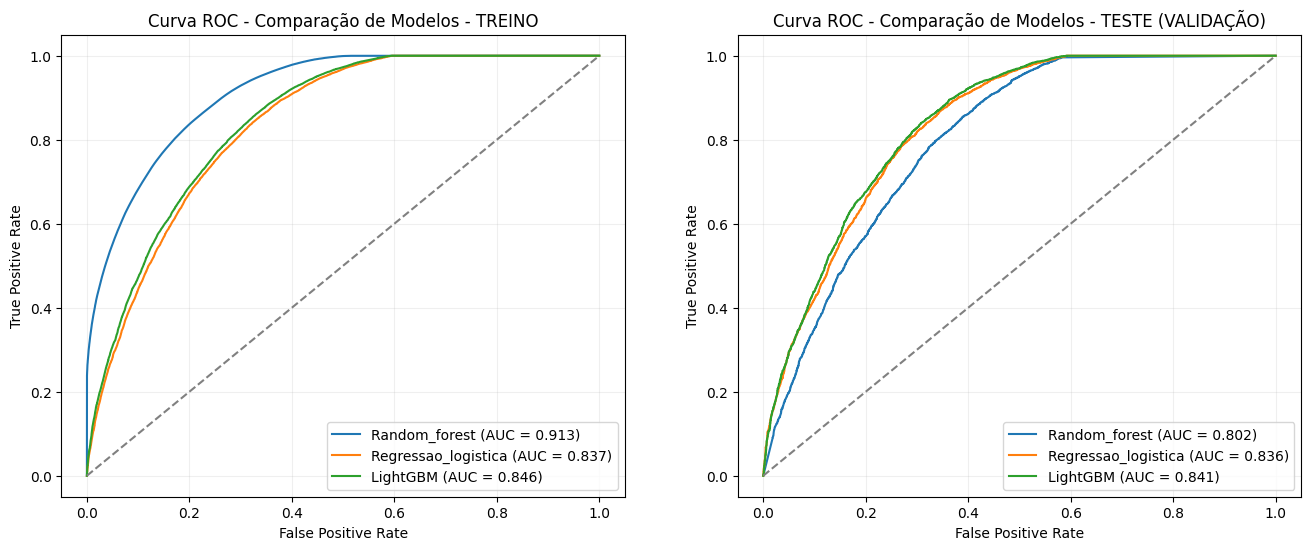

In [17]:

plt.figure(figsize=(16, 6))
### TREINO
plt.subplot(1, 2, 1)
plt.plot(fpr1_treino, tpr1_treino, label=f"{'Random_forest'} (AUC = {auc1_treino:.3f})")
plt.plot(fpr2_treino, tpr2_treino, label=f"{'Regressao_logistica'} (AUC = {auc2_treino:.3f})")
plt.plot(fpr3_treino, tpr3_treino, label=f"{'LightGBM'} (AUC = {auc3_treino:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparação de Modelos - TREINO")
plt.legend()
plt.grid(alpha=0.2)



### TESTE - VALIDAÇÃO
plt.subplot(1, 2, 2)
plt.plot(fpr1, tpr1, label=f"{'Random_forest'} (AUC = {auc1:.3f})")
plt.plot(fpr2, tpr2, label=f"{'Regressao_logistica'} (AUC = {auc2:.3f})")
plt.plot(fpr3, tpr3, label=f"{'LightGBM'} (AUC = {auc3:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparação de Modelos - TESTE (VALIDAÇÃO)")
plt.legend()
plt.grid(alpha=0.2)

plt.show()

##### Conclusão
_____

O que já conseguimos tirar de conclusão com essa comparação dos modelos é que temos: \
Random Forest aparentemente tem um overfitting \
Os outors modelos tem uma melhor generalização, porém LightGBM se sobresai no AUC


#### Analise de features Random Forest

In [18]:
preprocessor_fitted = pipe_model.named_steps['prep'].named_steps['pre']
feature_names = preprocessor_fitted.get_feature_names_out()
rf = pipe_model.named_steps['model']
importances = rf.feature_importances_

feat_imp_rf = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print("Top 20 features - Random Forest:")
print(feat_imp_rf.head(20))


Top 20 features - Random Forest:
                          feature  importance
0                      num__month    0.159102
1                 num__difficulty    0.137060
2                   num__duration    0.115303
3               num__reward_offer    0.100146
4   cat__offer_type_informational    0.067894
5                     num__gender    0.059439
6        cat__time_total_bin_600+    0.040396
7         cat__income_bin_0-40000    0.024289
8        cat__offer_type_discount    0.022307
9            cat__offer_type_bogo    0.021268
10   cat__income_bin_80000-100000    0.020114
11    cat__income_bin_40000-60000    0.019158
12    cat__time_total_bin_240-480    0.016872
13    cat__time_total_bin_480-600    0.016853
14             cat__age_bin_40-89    0.016674
15      cat__time_total_bin_0-120    0.016134
16                    num__social    0.015171
17                       num__web    0.014939
18    cat__income_bin_60000-80000    0.014431
19    cat__time_total_bin_120-240    0.014277


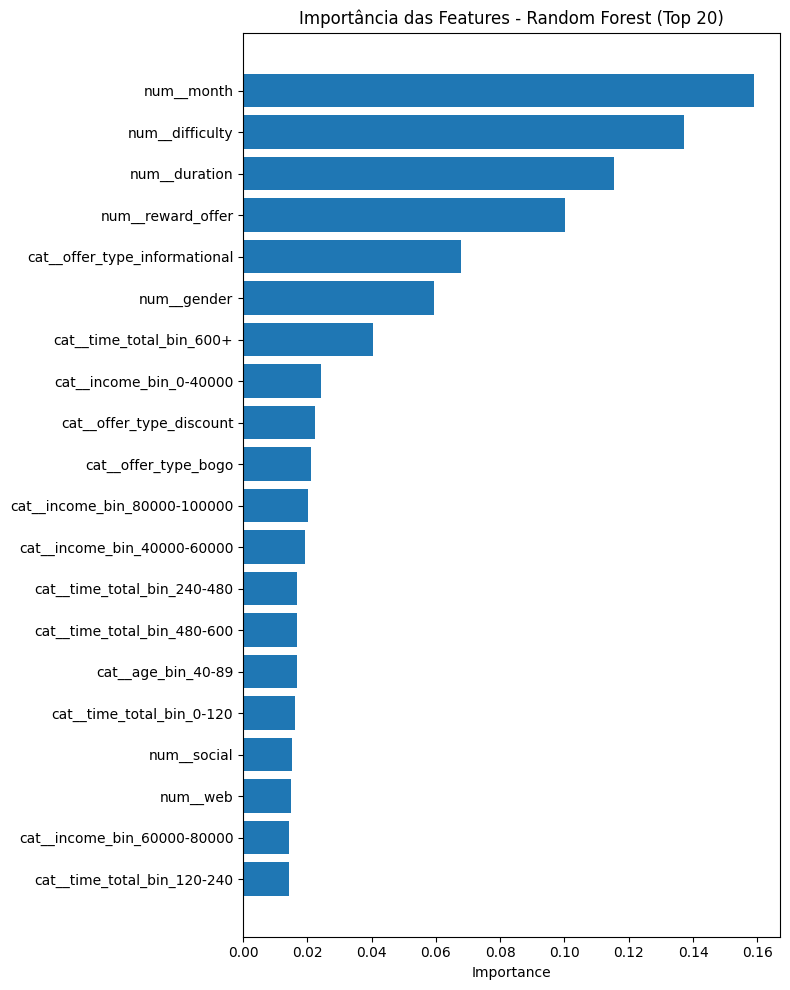

In [19]:
plt.figure(figsize=(8, 10))
plt.barh(feat_imp_rf['feature'].head(20), feat_imp_rf['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Importância das Features - Random Forest (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


#### Analise de features Regressão logistica

In [20]:
preprocessor_fitted_log = best_model.named_steps['prep'].named_steps['pre']

feature_names_log = preprocessor_fitted_log.get_feature_names_out()


log_reg = best_model.named_steps['model_reg_log']

coefs = log_reg.coef_[0]
intercepto = log_reg.intercept_[0]

feat_coef_log = (
    pd.DataFrame({
        'feature': feature_names_log,
        'beta': coefs,
        'abs_beta': np.abs(coefs)
    })
    .sort_values('abs_beta', ascending=False)
    .reset_index(drop=True)
)
print("\nMais influentes POSITIVAS (beta > 0):")
print(feat_coef_log[feat_coef_log['beta'] > 0].head(10))

print("\nMais influentes NEGATIVAS (beta < 0):")
print(feat_coef_log[feat_coef_log['beta'] < 0].head(10))


Mais influentes POSITIVAS (beta > 0):
                         feature      beta  abs_beta
1       cat__time_total_bin_600+  1.219362  1.219362
4        cat__income_bin_100000+  0.615467  0.615467
5   cat__income_bin_80000-100000  0.552632  0.552632
6       cat__offer_type_discount  0.468598  0.468598
9                  num__duration  0.314968  0.314968
13                   num__social  0.150726  0.150726
14            cat__age_bin_40-89  0.144661  0.144661
15            cat__season_Outono  0.137019  0.137019
17   cat__time_total_bin_240-480  0.119182  0.119182
18           cat__season_Inverno  0.110421  0.110421

Mais influentes NEGATIVAS (beta < 0):
                          feature      beta  abs_beta
0   cat__offer_type_informational -9.540215  9.540215
2         cat__income_bin_0-40000 -0.849701  0.849701
3                 num__difficulty -0.695584  0.695584
7     cat__income_bin_40000-60000 -0.454378  0.454378
8       cat__time_total_bin_0-120 -0.448426  0.448426
10    cat__time

#### Analise de features LightGBM

In [21]:
lgbm = best_model_2.named_steps['model']
importances_lgbm = lgbm.feature_importances_

feat_imp_lgbm = (
    pd.DataFrame({
        'feature': feature_names,
        'lgbm_importance': importances_lgbm
    })
    .sort_values('lgbm_importance', ascending=False)
    .reset_index(drop=True)
)

print("Top 20 features - LightGBM:")
print(feat_imp_lgbm.head(20))


Top 20 features - LightGBM:
                         feature  lgbm_importance
0                num__difficulty              328
1                     num__month              215
2                    num__gender              142
3   cat__income_bin_80000-100000              122
4       cat__time_total_bin_600+              117
5                  num__duration              111
6                    num__social              108
7              num__reward_offer               95
8             cat__age_bin_40-89               86
9        cat__income_bin_0-40000               77
10     cat__time_total_bin_0-120               76
11       cat__income_bin_100000+               70
12   cat__income_bin_40000-60000               62
13             cat__age_bin_0-24               54
14   cat__time_total_bin_240-480               49
15   cat__time_total_bin_120-240               49
16   cat__time_total_bin_480-600               40
17            cat__age_bin_25-39               38
18              cat__a

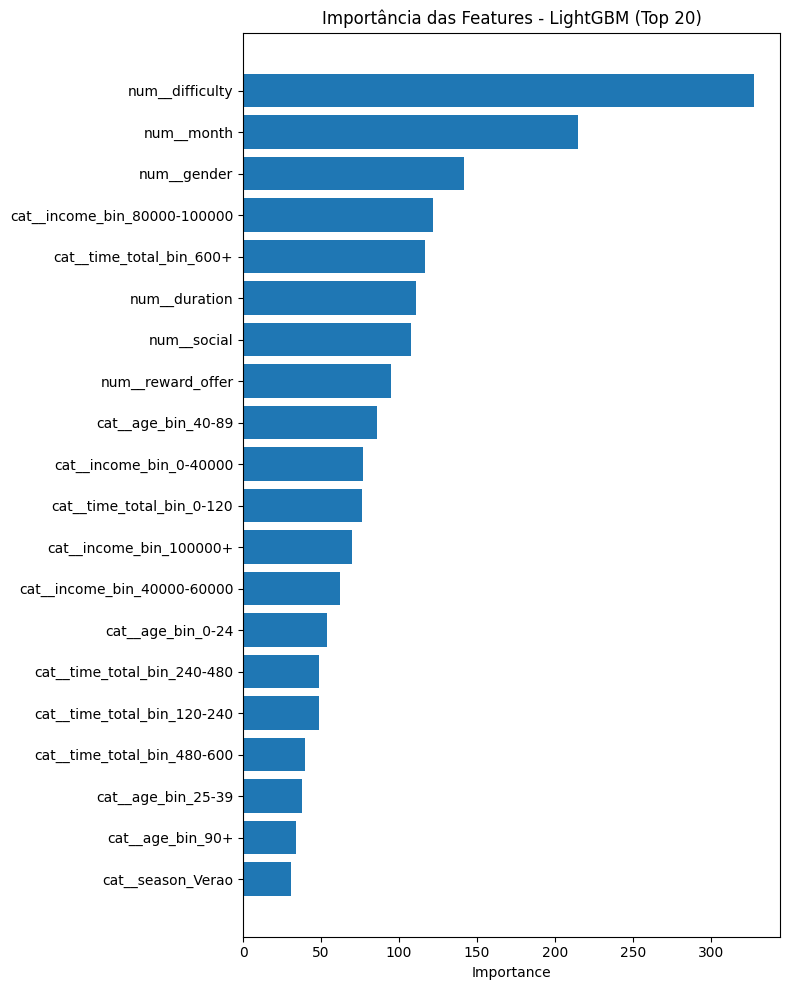

In [22]:
plt.figure(figsize=(8, 10))
top_lgbm = feat_imp_lgbm.head(20)
plt.barh(top_lgbm['feature'], top_lgbm['lgbm_importance'])
plt.gca().invert_yaxis()
plt.title("Importância das Features - LightGBM (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


<!-- # Validação Cruzada — Imputação de Renda (income)

## O que foi feito

1) **Definimos a variável-alvo (target)**  
   - Para cada cliente (`person`), marcamos `1` se ele **completou ao menos uma oferta** (`offer_completed`) e `0` caso contrário.  
   - Isso transforma o problema em **classificação binária** (completou vs. não completou).

2) **Juntamos o alvo com o perfil do cliente**  
   - Cruzamos com `df_profile_clean` para ter as features **`age`** e **`income`** (renda).

3) **Criamos duas versões do dataset** para testar o *tratamento de valores ausentes*:
   - **Sem imputação**: removemos linhas onde `income` era nulo (`NaN`).  
   - **Com imputação**: preenchemos `income` faltante com a **mediana** da renda.

4) **Treinamos e avaliamos um modelo igual nos dois cenários**  
   - Modelo: **RandomForestClassifier** (padrão, `random_state=42`).  
   - Validação: **5-fold Stratified Cross-Validation** (mantém a proporção de classes em cada dobra).  
   - Métrica: **accuracy** (acertos/total) em cada dobra; depois calculamos a **média**.

---

## Resultados

- **Sem imputação (descartando NaN)**  
  Acurácias por dobra: `[0.7514, 0.7518, 0.7538, 0.7535, 0.7514]`  
  **Média:** **0.7524**

- **Com imputação (mediana)**  
  Acurácias por dobra: `[0.7491, 0.7379, 0.7347, 0.7403, 0.7376]`  
  **Média:** **0.7399**

---

- A **validação cruzada** estima o desempenho **fora da amostra** (generalização) e reduz o risco de avaliar o modelo apenas em um único “corte” dos dados.
- O modelo **sem imputação** teve **accuracy médio ~1,25 p.p. maior** (*0,7524 vs 0,7399*).  
- Como o **modelo** e a **validação** foram idênticos nos dois cenários, a diferença se deve ao **tratamento de valores ausentes em `income`**.

---

## Conclusão 

- **Para este alvo e esse conjunto de features**, **descartar** as linhas sem `income` rendeu melhor desempenho do que **imputar por mediana**.  
- Possíveis razões:
  - As ausências de `income` **não são aleatórias** (o que a mediana não captura), introduzindo ruído.  
  - Preencher com um valor “típico” (mediana) **achata diferenças** entre clientes e reduz o sinal preditivo.

**Decisão prática:** para esta tarefa, **manter a versão sem imputação de `income`** foi **ligeiramente melhor**.  
(Anote no relatório que você testou os dois tratamentos e comparou com validação cruzada.)

--- -->



In [23]:
top_feats = feat_coef_log.head(30)['feature']

comparacao = pd.DataFrame({'feature': top_feats})

comparacao = (
    comparacao
    .merge(feat_coef_log[['feature', 'beta', 'abs_beta']], on='feature', how='left').round(2)
    .merge(feat_imp_rf[['feature', 'importance']], on='feature', how='left')
    .merge(feat_imp_lgbm[['feature', 'lgbm_importance']], on='feature', how='left')
    .reset_index(drop=True)
)

comparacao


,feature,beta,abs_beta,importance,lgbm_importance
0,cat__offer_type_informational,-9.54,9.54,0.067894,0
1,cat__time_total_bin_600+,1.22,1.22,0.040396,117
2,cat__income_bin_0-40000,-0.85,0.85,0.024289,77
3,num__difficulty,-0.70,0.70,0.137060,328
4,cat__income_bin_100000+,0.62,0.62,0.011606,70
5,cat__income_bin_80000-100000,0.55,0.55,0.020114,122
6,cat__offer_type_discount,0.47,0.47,0.022307,0
7,cat__income_bin_40000-60000,-0.45,0.45,0.019158,62
8,cat__time_total_bin_0-120,-0.45,0.45,0.016134,76
9,num__duration,0.31,0.31,0.115303,111


#### Visualização das feature Importance

100%|===================| 43981/44163 [03:15<00:00]        

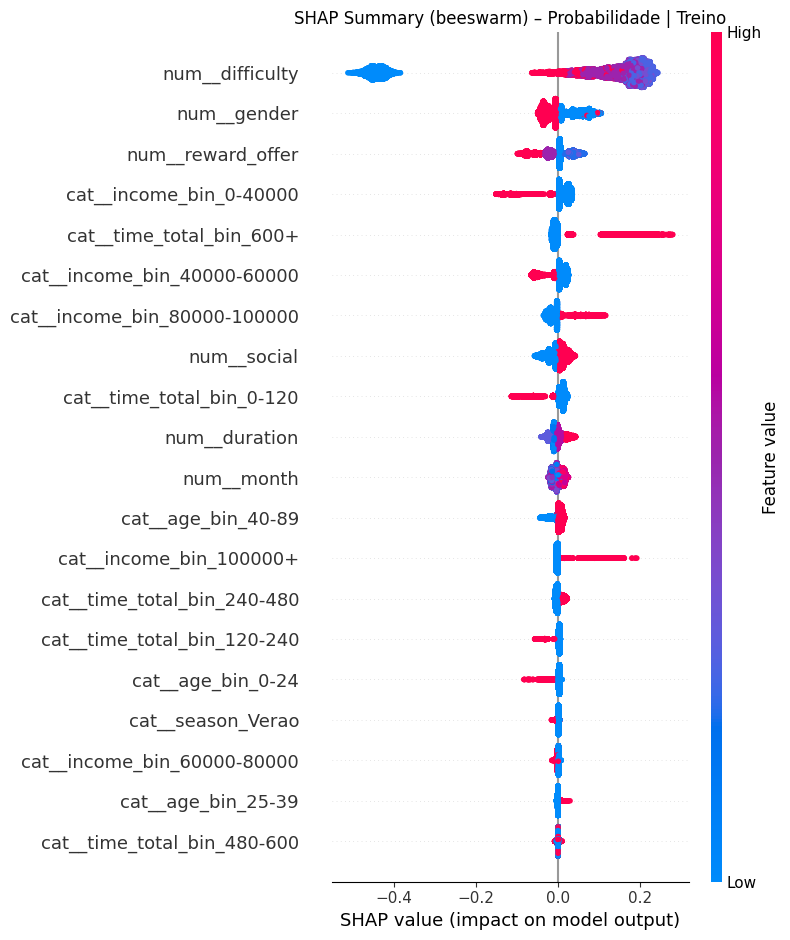

In [27]:
final_pipe = grid_2.best_estimator_

prep_best = final_pipe.named_steps['prep']
fe = prep_best.named_steps['fe']
pre = prep_best.named_steps['pre']

model = final_pipe.named_steps['model']
X_fe = fe.transform(x_train)

pre_pd = pre.set_output(transform='pandas')

X_train_t = pre_pd.transform(X_fe)

feature_names = list(X_train_t.columns)

explainer = shap.TreeExplainer(
    model,
    data=X_train_t,
    model_output='probability',
    feature_perturbation='interventional'
)

sv_tr = explainer.shap_values(X_train_t)

plt.figure()
shap.summary_plot(sv_tr, X_train_t, feature_names=feature_names, show=False)
plt.title('SHAP Summary (beeswarm) – Probabilidade | Treino')
plt.tight_layout()
plt.show()

#### Entendendo thresholds

In [31]:
x_test['predicao'] = y_proba_test_2
x_test['target'] = y_test
x_test

,person,offer_id,gender,age,became_member_on,income,reward_offer,difficulty,duration,offer_type,email,mobile,social,web,time_total,month,predicao,target
36344,478f3d690f8640e8b017e13a794936a0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,23,2017-06-18,48000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,534,6,0.589647,1.0
5843,d94526ca0f2846f9867a7895f625a8d6,f19421c1d4aa40978ebb69ca19b0e20d,M,75,2018-07-19,70000.0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,96,7,0.530352,1.0
46780,37a60351fd89457d8ea4b19df2b0b75f,f19421c1d4aa40978ebb69ca19b0e20d,M,20,2018-03-26,70000.0,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,660,3,0.714674,1.0
39654,158d8edca3b443c7a65eaffd591bdc27,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,49,2017-10-01,52000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,456,10,0.707315,1.0
55954,5eedd919fe494103b0aad8a02e89ca7c,2906b810c7d4411798c6938adc9daaa5,F,73,2017-08-25,82000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,714,8,0.934715,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55016,1dc38ca39f8440399792bedbf3e4ee84,5a8bc65990b245e5a138643cd4eb9837,F,50,2017-09-08,92000.0,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,576,9,0.000236,0.0
36106,2b305dbf84dd441ab8ea26242bcced60,4d5c57ea9a6940dd891ad53e9dbe8da0,F,51,2017-08-01,98000.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,414,8,0.780172,1.0
42538,fb7eb30e7d1b4d2ebf627fe51063234e,ae264e3637204a6fb9bb56bc8210ddfd,F,67,2015-11-23,50000.0,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,474,11,0.621919,1.0
47405,682db591325946118a74447bdb891603,0b1e1539f2cc45b7b9fa7c272da2e1d7,M,51,2017-01-31,75000.0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,534,1,0.467947,0.0


In [48]:
thresholds = np.arange(0.95, 0.0, -0.05)
resultado_threshold = []

for thresh in thresholds:
    y_pred = (y_proba_test_2 >= thresh).astype(int)
    ps = precision_score(y_test, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    targets = x_test[x_test['predicao'] >= thresh].target.sum()
    qtidade = x_test[x_test['predicao'] >= thresh].shape[0]
    rs = recall_score(y_test, y_pred)


    resultado_threshold.append({
    'Threshold': thresh,
    'precision': ps,
    'recall':rs,
    'target_1': targets,
    'total': qtidade,
    'fp': fp,
    'tp': tp

    })
resultado_threshold = pd.DataFrame(resultado_threshold)
resultado_threshold['prop_total']  = resultado_threshold['total']/(x_test['predicao'].count())
resultado_threshold = resultado_threshold[['Threshold','precision','recall','target_1','total','prop_total']]

resultado_threshold

,Threshold,precision,recall,target_1,total,prop_total
0,0.95,0.833333,0.000895,5.0,6,0.000543
1,0.90,0.920330,0.059961,335.0,364,0.032968
2,0.85,0.899142,0.149991,838.0,932,0.084413
3,0.80,0.860609,0.272955,1525.0,1772,0.160493
4,0.75,0.822592,0.424915,2374.0,2886,0.261389
5,0.70,0.802836,0.537140,3001.0,3738,0.338556
6,0.65,0.788568,0.639520,3573.0,4531,0.410379
7,0.60,0.762674,0.727045,4062.0,5326,0.482384
8,0.55,0.749155,0.793270,4432.0,5916,0.535821
9,0.50,0.728185,0.857347,4790.0,6578,0.595779


##### Conclusão
_____

Sempre interessante fazer um balanceamento dos threshold, pois é importante ver o qual corte comporta melhor ambas as métricas. \
Como nosso foco é a resposta da campanha, é interessante ter a precision alta, para avaliarmos o quanto que estamos seremos efetivos nos envios. \
Porém o recall bem balanceado também é de grande interesse, pois quanto enviamos e convertemos, quantos realmente converteriam.

- Essa tabela sempre é usada para levar ao time de negócio dando opções e métricas que ele desejam escolher do nosso modelo. \
Faixa conservadora: 0,30 - Com 66% de precision e 97% recall, então não somos tão precisos, porém acabamos acertando a maioria que realmente converteria as campanhas.\
Faixa média: 0,50 - 72% precision e 85% recall.\
Faixa escolhida: 0,65 - 78% precision e 63% de recall - Porém com 41% da base geral



In [47]:
y_pred_final = (y_proba_test >= 0.65).astype(int)
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

[[4488  966]
 [2168 3419]]
              precision    recall  f1-score   support

         0.0       0.67      0.82      0.74      5454
         1.0       0.78      0.61      0.69      5587

    accuracy                           0.72     11041
   macro avg       0.73      0.72      0.71     11041
weighted avg       0.73      0.72      0.71     11041

